# Analyze Purchase Records to Determine Sales-Tax Engine Solution
The purpose of this analysis is to analyze purchase records to locate transactions within states that collect sales tax.

I found a dataset called `iowa_liquor_sales` in Google's BigQuery Public Data Set which contains ~22.2 million records of transactional liqor sales data in the state of Iowa by county. I extracted 7 million rows of data for the purposes of this analysis.

This dataset will serve as a proxy, wherein I will analyze liquor sale transactions across counties in Iowa instead of technology sales transactions in states accross the United States. My goal with this analysis is to demonstrate analytics, SQL and data cleaning skills.

In [1]:
# import of necessary libraries
import pandas as pd
from dask import dataframe as ddf
from pathlib import Path
from sqlalchemy import create_engine
from time import time
import altair as alt

# Get data in usable format

Due to restrictions in how much data can be downloaded into a `.csv` file from BigQuery, I extracted the 7 million rows of data into three separate files.

Each of these files was loaded into a `sqlite` database table called `transactions` after performing a bit of data cleanup.
* Set correct data types for each column
* Set datetime data type for date columns
* Normalize county data so that all appear in uppercase, to avoid duplicates

I used the `dask` library to speed up computation time since 7 million rows is enough to bog down pandas. Getting all the data into a sqlite database helps to free up memory on my computer and allows me to do aggregations on the data and get it into bite-sized chunks to run an analysis.

In [2]:
# create the sql engine to interact with the database
db = 'sqlite:///database.db'
engine = create_engine(db, echo=False)

In [3]:
# specify the datatypes of columns to be read from csv files
dtypes = {
    'invoice_and_item_number':str,
    'store_number':int,
    'store_name':str,
    'address':str,
    'city':str,
    'zip_code':str,
    'store_location':str,
    'county_number':str,
    'county':str,
    'category':str,
    'category_name':str,
    'vendor_number':str,
    'vendor_name':str,
    'item_number':str,
    'item_description':str,
    'pack':int,
    'bottle_volume_ml':int,
    'state_bottle_cost':float,
    'state_bottle_retail':float,
    'bottles_sold':int,
    'sale_dollars':float,
    'volume_sold_liters':float,
    'volume_sold_gallons':float
}

date_cols = ['date']

In [4]:
# identify files to be processed
file_names = ['transactions.csv', 'transactions2.csv', 'transactions3.csv']

# load each file into transactions table in sqlite database
start_time = time()
for file in file_names:
    print(f'working on {file}...')
    
    print(f'\topening file')
    loc = Path.cwd().parent / 'data' / file
    df_dask = ddf.read_csv(loc, dtype=dtypes, parse_dates=date_cols)
    
    # clean up the 'county' data to standardize as all uppercase
    df_dask['county'] = df_dask['county'].str.upper()
    
    print(f'\twriting to sql database')
    df_dask.to_sql('transactions', db, if_exists='append', index=False)
end_time = time()
print(f'{round(end_time - start_time, 2)} seconds elapsed')

working on transactions.csv...
	opening file
	writing to sql database
working on transactions2.csv...
	opening file
	writing to sql database
working on transactions3.csv...
	opening file
	writing to sql database
295.62 seconds elapsed


In [5]:
# test to see if the load was successful - expecting 7M records
pd.read_sql_query('SELECT COUNT(*) FROM transactions', engine)

COUNT(*)
0   7000000

Now I have 7 million rows of transactional data in a database called `database`, in a table called `transactions`. Below is a preview.

In [6]:
pd.read_sql_query("SELECT * FROM transactions LIMIT 2", engine)

invoice_and_item_number                        date  store_number  \
0         INV-30243700036  2020-09-15 00:00:00.000000          4973   
1         INV-35778400094  2021-04-13 00:00:00.000000          3723   

                          store_name         address        city zip_code  \
0  Quillins Quality Foods West Union  303, Hwy 150 N  West Union    52175   
1                 J D Spirits Liquor    1023  9th St       Onawa  51040.0   

                 store_location county_number   county  ... item_number  \
0  POINT (-91.814402 42.965065)            33  FAYETTE  ...       33717   
1  POINT (-96.095845 42.025841)            67   MONONA  ...       33697   

     item_description pack bottle_volume_ml state_bottle_cost  \
0  Paramount Sloe Gin   12             1000              5.42   
1  Mr Boston Sloe Gin   12             1000              5.42   

  state_bottle_retail  bottles_sold  sale_dollars  volume_sold_liters  \
0                8.13             4         32.52                 4.0   
1                8.13             4         32.52                 4.0   

   volume_sold_gallons  
0                 1.05  
1                 1.05  

[2 rows x 24 columns]

# Analysis - Analyze Purchase Records
Individual transaction records are too granular. Now that I have the data stored in a SQL database, I can reduce the complexity and size of the data by running aggregation functions via SQL queries.

I will create a summary table aggregating the data:
* By month, county, and item
* Aggregate total sales dollars, total cost, count of transactions

In [7]:
# summarize the data
query = """
    SELECT
        strftime('%Y-%m', date) month,
        county,
        item_number,
        item_description,
        SUM(sale_dollars) sale_dollars,
        SUM(state_bottle_cost * bottles_sold) cost,
        COUNT(*) num_transactions
        
    FROM transactions
    
    WHERE county IS NOT NULL
    
    GROUP BY
        1, 2, 3, 4
"""
df = pd.read_sql_query(query, engine)

In [8]:
# check the size of the table
df.shape

(1948988, 7)

In [9]:
# preview the first five rows of the table
df.head()

month county item_number                   item_description  \
0  2012-01  ADAIR       15644                            Jameson   
1  2012-01  ADAIR       27102                      Templeton Rye   
2  2012-01  ADAIR       33716                 Paramount Sloe Gin   
3  2012-01  ADAIR       34001  Absolut Swedish Vodka 80 Prf Mini   
4  2012-01  ADAIR       34006       Absolut Swedish Vodka 80 Prf   

   sale_dollars    cost  num_transactions  
0         79.11   52.74                 3  
1        813.90  542.40                 5  
2         46.00   30.72                 2  
3         11.88    7.92                 1  
4        261.28  174.24                 2

While this is still a large dataset, it's much smaller and easier to work with aggregate data at ~2M rows compared to 7M rows.

I will add a new table called `summary` to the SQL database in case I'll want to work with it later, and clear out my memory so my computer doesn't slow down.

In [10]:
# add to sql database
df.to_sql('summary', engine, index=False, if_exists='replace')

## What do sales look like for taxable states?
Let's say I worked with the internal accounting group to identify counties (or states, municipalities, etc...) that are charging a sales tax which we will need to collect. I'd like to get a quick view of what sales look like by taxable vs non-taxable state.

To do this I will only look at the last 12 months of transactions and create a visualization of sales by county, with an indication of whether the county is taxable or not.

In [11]:
# filter down my dataset to only capture trailing 12 months of sales
county_sales_t12m = (
    df.loc[df['month'] >= '2020-10']
    .groupby(['county'], as_index=False)
    .agg({'sale_dollars':sum, 'num_transactions':sum})
)

In [12]:
# divide the total sales by 1,000,000 so that labels are prettier
county_sales_t12m['sale_dollars_m'] = county_sales_t12m['sale_dollars'] / 1000000

In [13]:
# open the file on which I worked with accounting to identify taxable counties
loc = Path.cwd().parent / 'data' / 'tax_counties.xlsx'
tax_counties_df = pd.read_excel(loc)

In [14]:
# merge with sales dataset, so that I can visualize it all together
county_sales_t12m = county_sales_t12m.merge(tax_counties_df, how='left', on='county')

In [15]:
# create a visualization
bars = alt.Chart(county_sales_t12m).mark_bar().encode(
    x=alt.X('sale_dollars_m:Q', title='Sales ($mm)', axis=alt.Axis(orient='top')),
    y=alt.Y('county', sort=alt.EncodingSortField(field='sale_dollars_m', op="sum",order='descending'), title='County'),
    color=alt.Color('tax_flag', legend=alt.Legend(title='Tax Flag', orient='left'))
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text=alt.Text('sale_dollars_m', format='$.2f')
)

chart = (bars + text)

chart.properties(
    title={
      "text": ["Trailing 12 Month Sales by County"], 
      "subtitle": ["Taxable vs. Non-Taxable"],
      "subtitleColor": "gray",
    }
).configure_title(
    anchor='start'
);

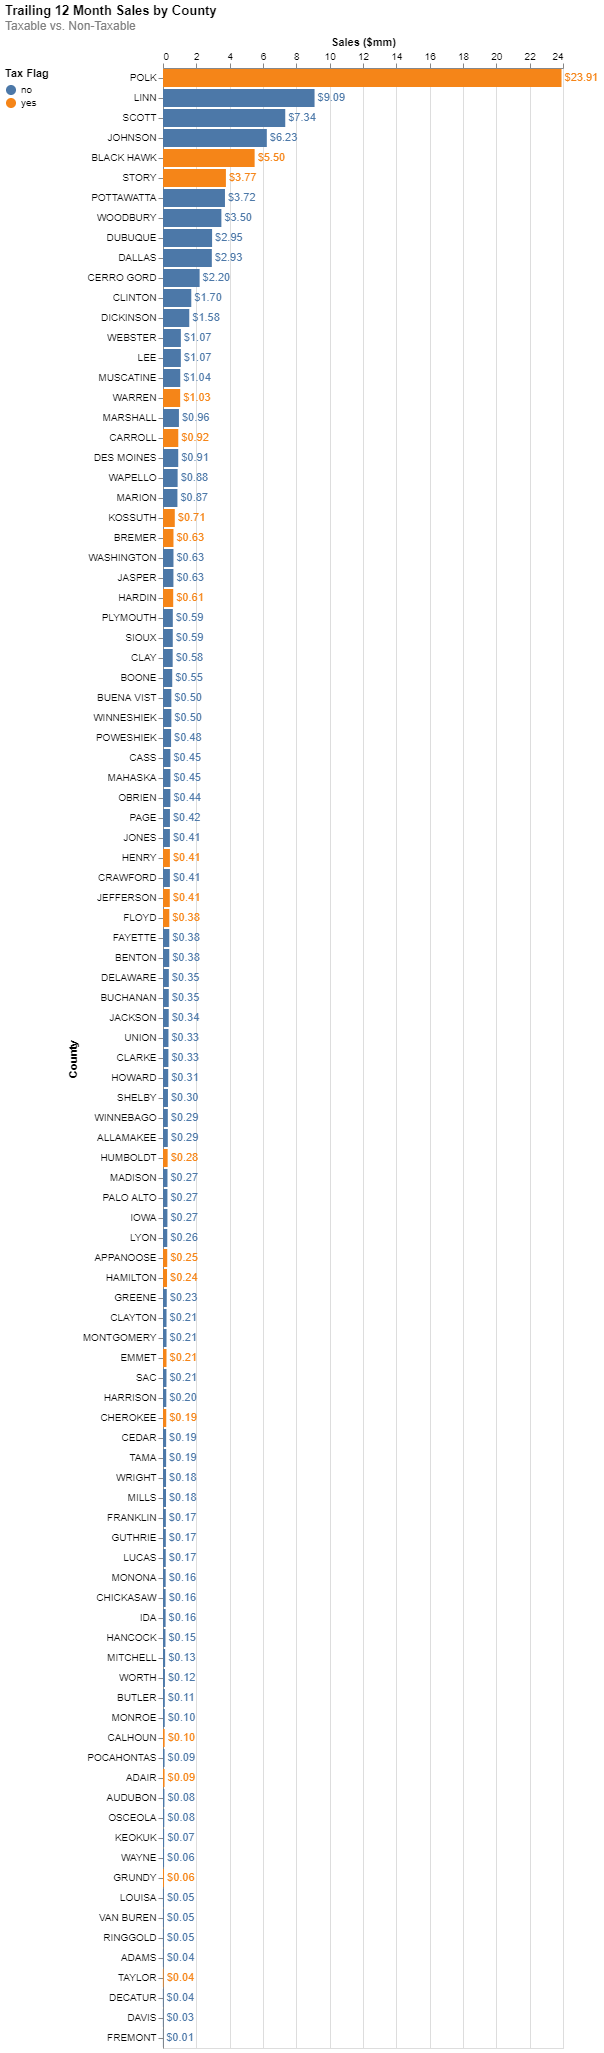

From this graph it's easy to see how sales break down for taxable counties, especially that Polk county, which has the most sales by far, is a taxable state.

To get more of the details I'll create and format a pivot table of the data.

In [16]:
# create the pivot table, with count and sum of sales
pivot_df = county_sales_t12m.pivot_table(values=['sale_dollars', 'num_transactions'], index=['tax_flag'], aggfunc=['count', 'sum'], margins=True)
# remove redundant column
del pivot_df[('count', 'num_transactions')]
# calculate share of sales
pivot_df['sales_share'] = pivot_df['sum', 'sale_dollars'] / county_sales_t12m['sale_dollars'].sum()
pivot_df['trans_count_share'] = pivot_df['sum', 'num_transactions'] / county_sales_t12m['num_transactions'].sum()
# rename columns for easy data manipulation
pivot_df.columns = ['county_count', 'transaction_count', 'sum_sales', 'share_sales', 'trans_count_share']
# reorder columns
pivot_df = pivot_df[['county_count', 'transaction_count', 'trans_count_share', 'sum_sales', 'share_sales']]
# format the output to make it easier to read
format_dict = {'sum_sales':'${0:,.0f}', 'share_sales':'{:.2%}', 'transaction_count':'{:,}', 'trans_count_share':'{:.2%}'}
pivot_df.style.format(format_dict);

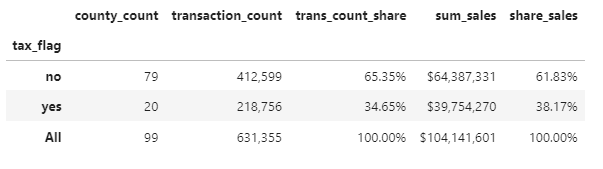

We can see that although only 20 out of 99 counties collect sales tax, they make up almost 38% of sales, and ~35% of the transaction count.

## Next Steps
Armed with the information I was able to uncover with this analysis of transactions, I can take the following next steps:<br>
1) Communicate the findings to the accounting group and make sure they understand exactly how I sourced the data so they can pressure test my approach. Then I can create a table in the cloud data warehouse that gets automatically populated with new transacional data on a daily basis (or whatever cadence is necessary for the task) so that it is easily accessible going forward. This creates a stable data source instead of a brittle, 'hacked-together' process.<br>
2) At the same time I can reach out to vendors that offer sales-tax engine solutions, get demos and compare the solutions against each other. Depending on the offerings and costs, a cost-benefit analysis can be done to evaluate whether it makes more sense to use a vendor or whether it is worth the effort to build our own tax-engine solution.